## Simulation test case - optimize mesh to make triangles equilateral

Let's start with a simple test case to see whether the technology developed so far actually works.
The goal is to move the vertices $\mathbf{v}_i$ of triangulation so all triangle edge lengths are as close to some $\ell_0$ as possible. 
We specify a pseudo-energy $E=\sum_{ij} (|\mathbf{v}_i-\mathbf{v}_j| - \ell_0)^2$, and then minimize it using the JAX-provided gradients w.r.t the vertex positions.

This defines the "forward pass" of our "dynamical" model. In a second step, we can optimize over the model parameters, like $\ell_0$, to make the dynamics return some desired shape, for examlpe.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import copy

from tqdm.notebook import tqdm

In [2]:
import jax
import jax.numpy as jnp

In [3]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_log_compiles', False)

In [ ]:
from typing import Tuple

import dataclasses

import functools

In [ ]:
# import previously defined modules
from triangulax import mesh as msh
from triangulax.mesh import TriMesh, HeMesh, GeomMesh

#### JAX-compatible scientific computing libraries - useful in future steps
```
import diffrax # ODE solvers
import lineax # linear solvers
import optimistix # optimisation (scientific-computing style, e.g. conjugate gradient)
import optax # optimisation (ML-style, e.g. ADAM)
```

### Forward pass - minimize energy

In [6]:
import equinox as eqx

# equinox has automated "filtering" of JAX-transforms. So we can work with objects which are not just pytrees of arrays
# (like neural networks) and appy jit, vmap etc

In [7]:
# load example mesh
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, vertices=mesh.vertices)

hemesh

  o flat_tri_ecmc


HeMesh(N_V=131, N_HE=708, N_F=224)

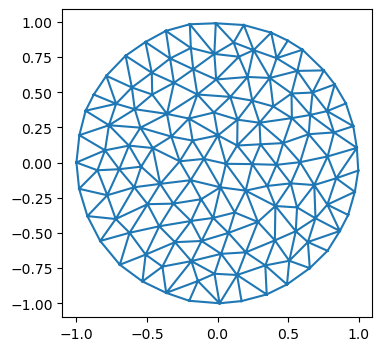

In [8]:
fig = plt.figure(figsize=(4, 4))
plt.triplot(*geommesh.vertices.T, mesh.faces)
plt.axis("equal");

In [9]:
lengths = jnp.linalg.norm(geommesh.vertices[hemesh.orig]-geommesh.vertices[hemesh.dest], axis=1)
tri_areas = -jax.vmap(msh.get_polygon_area)(geommesh.vertices[hemesh.faces])

lengths.mean(), tri_areas.mean()

(Array(0.18296366, dtype=float64), Array(0.01391806, dtype=float64))

We write the energy_function using a geommesh as an argument. This is overkill for present purposes ince only the vertex positions matter, but is useful to test the machinery. For more complicated simulations, we will want to use GeomMesh as a wrapper for the various arrays.

In [10]:


@jax.jit
def energy_function(geommesh: GeomMesh, hemesh: HeMesh, ell_0: float=1):
    edge_lengths = jnp.linalg.norm(geommesh.vertices[hemesh.orig]-geommesh.vertices[hemesh.dest], axis=1)
    edge_energy = jnp.mean((edge_lengths/ell_0-1)**2) # this way, term is "auto-normalized"
    # let's add a term for the triangle areas
    a_0 = (np.sqrt(3)/4) * ell_0**2 # area of equilateral triangle
    tri_area = -jax.vmap(msh.get_polygon_area)(geommesh.vertices[hemesh.faces])
    area_energy = jnp.mean((tri_area/a_0-1)**2)
    #jax.debug.print("E_l: {E_l}, E_a: {E_a}",  E_l=edge_energy, E_a=area_energy)
    # this is how you can print inside a JITed-function
    return edge_energy + area_energy


In [11]:
energy_function(geommesh, hemesh)

Array(1.60519339, dtype=float64)

In [12]:
# using functools.partial, we can fill in some of our function's args, like so:

functools.partial(energy_function, hemesh=hemesh, ell_0=1)(geommesh)

Array(1.60519339, dtype=float64)

In [13]:
val, grad = jax.value_and_grad(energy_function)(geommesh, hemesh) # computing value and grad works

val, grad, grad.vertices.shape # the gradient is another GeomMesh with the same structure

(Array(1.60519339, dtype=float64),
 GeomMesh(D=2,N_V=131, N_HE=708, N_F=224),
 (131, 2))

In [14]:
connectivity_grad = jax.grad(energy_function, argnums=1, allow_int=True)(geommesh, hemesh)
# we can even compute the gradient w.r.t to the connectivity matrix. It is also a HeMesh
connectivity_grad, connectivity_grad.dest[0] # whatever that means

(HeMesh(N_V=131, N_HE=708, N_F=224), np.void((b'',), dtype=[('float0', 'V')]))

#### Optimization run

In [15]:
# parameters of the energy
ell_0 = 0.5

# parameters of the "optimizer"
step_size = 0.05
N_steps = 10000

@jax.jit
def make_step(geommesh: GeomMesh, hemesh: HeMesh, ell_0: float = 1, step_size: float = 0.01):
    loss, grad = jax.value_and_grad(energy_function)(geommesh, hemesh, ell_0=ell_0)

    # update - can be streamlined with equinox
    updated_vertices = geommesh.vertices - step_size*grad.vertices
    geommesh_updated = dataclasses.replace(geommesh, vertices=updated_vertices)
    return geommesh_updated, hemesh, loss # explicitly return the hemesh - may need to be updated by flips!

# define inital condition
geommesh_optimized = copy.copy(geommesh)
hemesh_optimized = copy.copy(hemesh)

losses = []

for step in range(N_steps):
    geommesh_optimized, hemesh_optimized, loss = make_step(geommesh_optimized, hemesh_optimized,
                                                           ell_0=ell_0, step_size=step_size)
    losses.append(loss)

losses = np.array(losses)

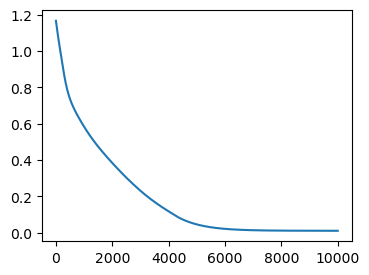

In [16]:
fig = plt.figure(figsize=(4, 3))
plt.plot(losses)

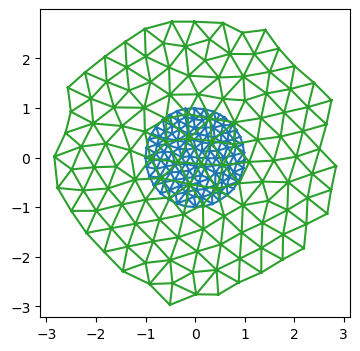

In [17]:
fig = plt.figure(figsize=(4, 4))
plt.triplot(*geommesh.vertices.T, hemesh.faces)
plt.triplot(*geommesh_optimized.vertices.T, hemesh_optimized.faces)
plt.axis("equal");

In [18]:
lengths_optimized = jnp.linalg.norm(geommesh_optimized.vertices[hemesh_optimized.orig]
                                   -geommesh_optimized.vertices[hemesh_optimized.dest], axis=1)
jnp.abs(lengths_optimized-ell_0).mean(), lengths_optimized.mean()

(Array(0.03342644, dtype=float64), Array(0.50208086, dtype=float64))

#### Using an ODE solver - `diffrax`

Above, we implemented "gradient descent" for the pseudo-energy, or, equivalently, a basic forward-Euler scheme for the ODE $\partial_t \mathbf{v}_i = - \nabla_{\mathbf{v}_i} E$. For more complicated models, and to minimize coding effort, it makes sense to use a pre-made ODE solver instead. The `diffrax` library implements ODE and SDE solvers in JAX and is compatible with autodiff (you can differentiate through the solver), since it was designed for neural differential equations.

For "adiabatic" dynamics, which involve mimizing an energy at every timestep, we can use the "optimistix" library.

The below is based on the [Stepping through a solver](https://docs.kidger.site/diffrax/usage/manual-stepping/) tutorial in `diffrax`. The reason we want to step through the solver one-by-one is to carry out T1s (in future simulations).

In [46]:
import diffrax

In [45]:
# load example mesh
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, vertices=mesh.vertices)


  o flat_tri_ecmc


In [105]:
# define the RHS for the ODE solver
@jax.jit
def vector_field(t, y, args):
    return jax.tree_util.tree_map(lambda x: -1*x, jax.grad(energy_function)(y, *args))
term = diffrax.ODETerm(vector_field)

# define time parameters and initial condition
dt = 0.05
t0 = 0.0
t1 = 1000.0
step_times = jnp.arange(t0, t1, dt)

y0 = geommesh
args = (hemesh, 0.5)

In [ ]:
# go step by step

solver = diffrax.Tsit5()
y = y0
state = solver.init(term, t0, t0+dt, y0, args)

def scan_fun(carry, t):
    state, y, tprev = carry 
    y, _, _, state, _ = solver.step(term, tprev, t, y, args, state, made_jump=False)
    return (state, y, t), None

init = (state, y0, t0)
(state, y, t), _ = jax.lax.scan(scan_fun, init, step_times[1:])

# equivalent to:

#for tprev, tnext in tqdm(zip(step_times[:-1], step_times[1:])):
#    y, _, _, state, _ = solver.step(term, tprev, tnext, y, args, state, made_jump=False)
#    tprev = tnext
#    tnext = min(tprev + dt0, t1)

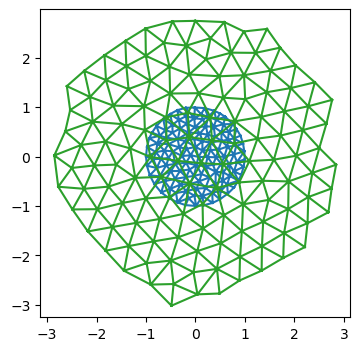

In [108]:
fig = plt.figure(figsize=(4, 4))
plt.triplot(*y0.vertices.T, hemesh.faces)
plt.triplot(*y.vertices.T, hemesh.faces)
plt.axis("equal");

### Meta-training

Eventually, we aim to learn some dynamical rules for a tissue mechanics model that make the tissue carry out some desired behavior, like making a target shape.

As a toy example, let's take the above "dynamics" which minimizes the pseudo-energy to make all triangles equilateral. It depends on the parameter $\ell_0$. Relaxation of the pseudo-energy for some number of steps defines our "forward pass". Let's try to optimize $\ell_0$ so that the tissue, at the end of the energy relaxation, has some target size (of course, a contrived problem, since we know the solution from the start).

In [19]:
# package the whole training process into a JITed function

@functools.partial(jax.jit, static_argnames=['N_steps'])
def relax_energy(initial_geommesh: GeomMesh, initial_hemesh: HeMesh, ell_0: float = 1,
                 step_size: float = 0.01, N_steps: int = 1):

    # define initial condition
    geommesh_optimized = copy.copy(initial_geommesh)
    hemesh_optimized = copy.copy(initial_hemesh)

    # use a jax.lax.fori_loop loop for training. Much faster JIT-compilation than a Python for loop.
    loss = 0
    init = (initial_geommesh, initial_hemesh, loss)
    def loop_fun(i, carry): return make_step(carry[0], carry[1], ell_0=ell_0, step_size=step_size) 
    geommesh_optimized, hemesh_optimized, loss = jax.lax.fori_loop(0, N_steps, loop_fun, init, unroll=None)
    
    return (geommesh_optimized, hemesh_optimized), loss

In [20]:
(geommesh_optimized, hemesh_optimized), losses = relax_energy(geommesh, hemesh, ell_0=0.5, step_size=0.05, N_steps=5000)
losses

Array(0.04463656, dtype=float64)

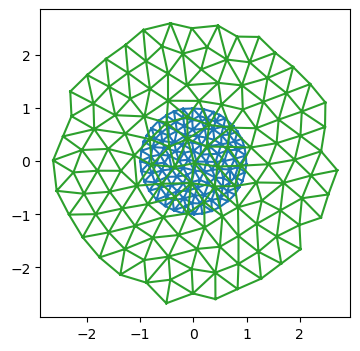

In [21]:
fig = plt.figure(figsize=(4, 4))
plt.triplot(*geommesh.vertices.T, hemesh.faces)
plt.triplot(*geommesh_optimized.vertices.T, hemesh_optimized.faces)
plt.axis("equal");

In [22]:
#| notest

%%timeit _ = relax_energy(geommesh, hemesh, ell_0=0.5, step_size=0.05, N_steps=5000)

UsageError: Line magic function `%%timeit` not found.


#### Define Meta-training loss

Now we need to define our meta-training loss. In this case, it's just the deviation of the average edge length from the total.
Note how the meta-loss is _distinct_ from the pseudo-energy we minimize during the forward pass.

Let's use the `equinox` library to handle our problem, in anticipation of more complex ones down the line.

In [23]:
class RelaxationDynamics(eqx.Module): # we create a model wrapping our relaxational dynamics 
    ell_0: jax.Array
    step_size : float = eqx.field(static=True)
    N_steps : int = eqx.field(static=True)

    def __call__(self, initial_geommesh: GeomMesh, initial_hemesh: HeMesh) -> Tuple[GeomMesh, HeMesh]:
        init = (initial_geommesh, initial_hemesh, 0)
        def loop_fun(i, carry): return make_step(carry[0], carry[1], ell_0=self.ell_0, step_size=self.step_size)
        geommesh_optimized, hemesh_optimized, loss = jax.lax.fori_loop(0, N_steps, loop_fun, init, unroll=None)
        return geommesh_optimized, hemesh_optimized

In [24]:
# define the meta-loss

def meta_loss(model: RelaxationDynamics, initial_geommesh: GeomMesh, initial_hemesh: HeMesh,  meta_ell0: float) -> float:
    geommesh_optimized, hemesh_optimized = model(initial_geommesh, initial_hemesh)
    lengths = jnp.linalg.norm(geommesh_optimized.vertices[hemesh_optimized.orig]
                              -geommesh_optimized.vertices[hemesh_optimized.dest], axis=-1)
    return jnp.mean((lengths/meta_ell0-1)**2)

In [25]:
# initialize the model, and test evaluating it

step_size = 0.01
N_steps = 20000

initial_ell0 = 0.4

meta_ell0 = 0.3

model_initial = RelaxationDynamics(ell_0=jnp.array([initial_ell0]), step_size=step_size, N_steps=N_steps)
model_initial(geommesh, hemesh), meta_loss(model_initial, geommesh, hemesh, meta_ell0=meta_ell0)

((GeomMesh(D=2,N_V=131, N_HE=708, N_F=224),
  HeMesh(N_V=131, N_HE=708, N_F=224)),
 Array(0.11642016, dtype=float64))

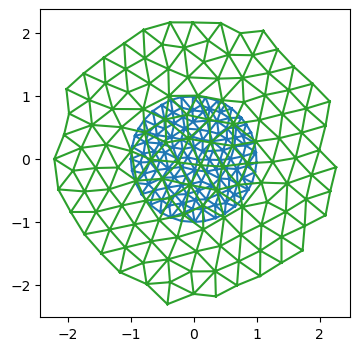

In [26]:
# let's check that the model still does what we want - looks good!
geommesh_trained, hemesh_trained = model_initial(geommesh, hemesh)

fig = plt.figure(figsize=(4, 4))
plt.triplot(*geommesh.vertices.T, hemesh.faces)
plt.triplot(*geommesh_trained.vertices.T, hemesh_trained.faces)
plt.axis("equal");

#### Batching

To evaluate the loss, we want to average over a bunch of initial conditions. These are analogous to _batches_ in a normal ML problem.

In [28]:
## Let us create a bunch of meshes with different initial positions and see if we can batch over them using vmap

key = jax.random.key(0)
sigma = 0.02

batch_geom = []
batch_he = []
for i in range(3):
    key, subkey = jax.random.split(key)
    random_noise = jax.random.normal(subkey, shape=geommesh.vertices.shape)
    batch_geom.append(dataclasses.replace(geommesh, vertices=geommesh.vertices+sigma*random_noise))
    batch_he.append(copy.copy(hemesh))

# we use a jax.tree.map to "push" the list axis into the underlying arrays.
batch_he_array = msh.tree_stack(batch_he)
batch_geom_array = msh.tree_stack(batch_geom)
batch_geom_array, batch_geom_array.vertices.shape

(GeomMesh(D=2,N_V=131, N_HE=708, N_F=224), (3, 131, 2))

In [29]:
# The result is a single mesh object with batch axes

batch_geom_array_out, batch_he_array_out = jax.vmap(model_initial)(batch_geom_array, batch_he_array) 
batch_geom_array_out, batch_geom_array_out.vertices.shape, batch_he_array_out.orig.shape

(GeomMesh(D=2,N_V=131, N_HE=708, N_F=224), (3, 131, 2), (3, 708))

In [30]:
# we can unpack things again into a list of meshes

batch_geom_out = msh.tree_unstack(batch_geom_array_out)
batch_he_out = msh.tree_unstack(batch_he_array_out)

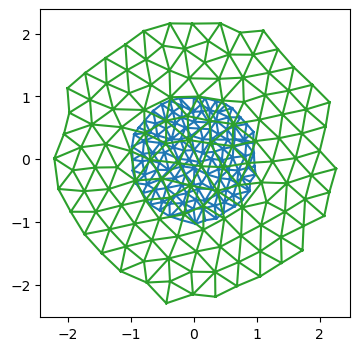

In [31]:
# still works

i = 2
fig = plt.figure(figsize=(4, 4))
plt.triplot(*batch_geom[i].vertices.T, batch_he[i].faces)
plt.triplot(*batch_geom_out[i].vertices.T, batch_he_out[i].faces)
plt.axis("equal");

In [32]:
# the batches are not identical, which is good.
not np.allclose(batch_geom_out[0].vertices, batch_geom_out[1].vertices)

True

##### Compute the batched loss

In [33]:
# This is the right way to vmap the loss
jax.vmap(meta_loss, in_axes=(None, 0,0, None))(model_initial, batch_geom_array, batch_he_array, 0.8) 

Array([0.25692552, 0.25749475, 0.25687504], dtype=float64)

In [34]:
# check against non-vmapped version. pretty similar, floating point errors likely at origin of differences
[meta_loss(model_initial, batch_geom_out[i], batch_he_out[i], 0.8) for i in range(3)] 

[Array(0.24862364, dtype=float64),
 Array(0.24863551, dtype=float64),
 Array(0.24863234, dtype=float64)]

### Outer optimization

Now we are in a position to "optiomize" our model parameter `ell_0`. Based on [equinox CNN tutorial](https://docs.kidger.site/equinox/examples/mnist/#training).

In [35]:
def batched_meta_loss(model, batch_geom_array, batch_he_array, meta_ell0):
    return jnp.mean(jax.vmap(meta_loss, in_axes=(None, 0,0, None))(model, batch_geom_array, batch_he_array, meta_ell0))

batched_meta_loss_jit = jax.jit(batched_meta_loss)

In [36]:
#| notest

## Let's do a short profiling run - how much does JIT-compilation save? I guess a little!
%timeit batched_meta_loss_jit(model_initial, batch_geom_array, batch_he_array, 0.2).block_until_ready()

372 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
#| notest

%timeit batched_meta_loss(model_initial, batch_geom_array, batch_he_array, 0.2).block_until_ready()

474 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
# hyper-parameters for the outer learning step.

BATCH_SIZE = 3
LEARNING_RATE = 1e-2
LEARNING_STEPS = 20
print_every = 2

step_size = 0.01
N_steps = 20000

META_ELL0 = 0.4
initial_ell0 = 0.2

model_initial = RelaxationDynamics(ell_0=jnp.array([initial_ell0]), step_size=step_size, N_steps=N_steps)

In [39]:
loss, grads = eqx.filter_jit(eqx.filter_value_and_grad(batched_meta_loss))(model_initial,
                                                                           batch_geom_array, batch_he_array, META_ELL0)

In [40]:
loss, grads, grads.ell_0

(Array(0.24848878, dtype=float64),
 RelaxationDynamics(ell_0=f64[1], step_size=0.01, N_steps=20000),
 Array([-2.48070057], dtype=float64))

#### Forward and reverse mode autodiff

Since we are differentiation w.r.t. a small number of parameters (justy 1:  $\ell_0$), we can use forward mode automatic differentiation for increased efficiency. This may be the case more generally: if we want to learn "translationally invariant" models, where the parameters for all cells are equal, the parameter count we want to differentiate by may be small. Forward mode autodiff is also somewhat more "forgiving" when it comes to control flow.

See: https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html


In [41]:
@eqx.filter_jit
def outer_optimizer_step(model: RelaxationDynamics,
                         batch_geom: GeomMesh, batch_he: HeMesh) -> Tuple[RelaxationDynamics, float]:
    
    # compute loss and grad on batch
    
    #loss, grads = eqx.filter_value_and_grad(batched_meta_loss)(model, batch_geom_array, batch_he_array, META_ELL0)
    #updates = jax.tree.map(lambda g: None if g is None else -LEARNING_RATE * g, grads)
    #model = eqx.apply_updates(model, updates)
    # grads is a PyTree with the same leaves as the trainable arrays of the model

    # same story, but using forward mode autodiff
    loss, grads = eqx.filter_jvp(lambda model: batched_meta_loss(model, batch_geom_array, batch_he_array, META_ELL0),
                                 primals=[model,], tangents=[model,])
    grads = grads/model.ell_0 # we used the current model values as a tangent vector, so we need to normalize
    model = dataclasses.replace(model, ell_0=model.ell_0-LEARNING_RATE*grads)
    
    return model, loss

In [42]:
model_stepped, loss = outer_optimizer_step(model_initial, batch_geom_array, batch_he_array)

In [43]:
loss, model_initial.ell_0, model_stepped.ell_0

(Array(0.24848878, dtype=float64),
 Array([0.2], dtype=float64),
 Array([0.22480701], dtype=float64))

In [44]:
#| notest

model = model_initial

for step in tqdm(range(LEARNING_STEPS)): # in the future, could also iterate over the initial conditions/batches
    model, loss = outer_optimizer_step(model, batch_geom_array, batch_he_array)
    if (step % print_every) == 0:
        print(f"Step: {step}, loss: {loss}, param: {model.ell_0}")

# 19s with forward mode vs 32s with reverse mode. 

  0%|          | 0/20 [00:00<?, ?it/s]

Step: 0, loss: 0.24848877513396528, param: [0.22480701]
Step: 2, loss: 0.14704976288187782, param: [0.26531774]
Step: 4, loss: 0.08837946252729874, param: [0.29610925]
Step: 6, loss: 0.05458715535792681, param: [0.31944763]
Step: 8, loss: 0.03524215346058198, param: [0.33709312]
Step: 10, loss: 0.024176542728598434, param: [0.35045283]
Step: 12, loss: 0.017795094517620076, param: [0.36062556]
Step: 14, loss: 0.01405819184500635, param: [0.36843856]
Step: 16, loss: 0.0118282405357572, param: [0.37449757]
Step: 18, loss: 0.0104714494134906, param: [0.37924151]


Looks good -  the optimizer converges to the correct value of $\ell_0$.

###  Next steps

Success: we can solve this (stupid) toy problem. Our JAX-compatible infrastructure for vertex models seems to work, and we can autodiff through a simulation. Next steps: 

1. Toy simulations _with T1s_
2. More complex models - say, the area-perimeter vertex model
3. Play around with neural ODEs and neural optimizers more generally.


